In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

导入数据

In [4]:
data = pd.read_csv('train_user.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256906 entries, 0 to 12256905
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int64 
 1   item_id        int64 
 2   behavior_type  int64 
 3   user_geohash   object
 4   item_category  int64 
 5   time           object
dtypes: int64(4), object(2)
memory usage: 561.1+ MB


In [5]:
data.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,98047837,232431562,1,NaN,4245,2014-12-06 02
1,97726136,383583590,1,NaN,5894,2014-12-09 20
2,98607707,64749712,1,NaN,2883,2014-12-18 11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10
4,98145908,290208520,1,NaN,13926,2014-12-16 21


数据预处理

In [6]:
df = data.drop_duplicates(inplace=False)
df1 = df.reset_index(drop=True)

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8164040 entries, 0 to 8164039
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int64 
 1   item_id        int64 
 2   behavior_type  int64 
 3   user_geohash   object
 4   item_category  int64 
 5   time           object
dtypes: int64(4), object(2)
memory usage: 373.7+ MB


In [8]:
df1.isnull().sum()

user_id                0
item_id                0
behavior_type          0
user_geohash     4308015
item_category          0
time                   0
dtype: int64

In [9]:
df1.drop('user_geohash',axis=1,inplace=True)

In [10]:
df1['date'] = df1['time'].str[0:10]
df1['date'] = pd.to_datetime(df1['date'],format='%Y-%m-%d')
df1['time'] = df1['time'].str[11:]
df1['time'] = df1['time'].astype(int)
df1['hour'] = pd.cut(df1['time'],bins=[-1,5,10,13,18,24],labels=['凌晨','上午','中午','下午','晚上'])
df1.head()

,user_id,item_id,behavior_type,item_category,time,date,hour
0,98047837,232431562,1,4245,2,2014-12-06,凌晨
1,97726136,383583590,1,5894,20,2014-12-09,晚上
2,98607707,64749712,1,2883,11,2014-12-18,中午
3,98662432,320593836,1,6562,10,2014-12-06,上午
4,98145908,290208520,1,13926,21,2014-12-16,晚上


rfm模型

In [11]:
buy_again = df1[df1['behavior_type']==4].groupby('user_id')['item_id'].count().reset_index()
buy_again.rename(columns={'item_id':'buy_again'},inplace=True)
buy_again.head()

,user_id,buy_again
0,4913,6
1,6118,1
2,7528,6
3,7591,21
4,12645,8


In [12]:
users = df1['user_id'].unique()
labels = pd.DataFrame(users,columns=['user_id'])

In [13]:
counts_30_active = df1.groupby('user_id')['date'].nunique()
counts_30_active.head()

user_id
4913     29
6118     12
7528     15
7591     25
12645    20
Name: date, dtype: int64

In [15]:
labels = pd.merge(labels,counts_30_active,how='left',on='user_id')
labels.rename(columns={'date':'counts_30_active'},inplace=True)
labels.head()

,user_id,counts_30_active
0,98047837,30
1,97726136,28
2,98607707,31
3,98662432,8
4,98145908,11


In [16]:
labels = pd.merge(labels,buy_again,how='left',on='user_id')
labels.fillna(0, inplace=True)
labels

,user_id,counts_30_active,buy_again
0,98047837,30,7.0
1,97726136,28,6.0
2,98607707,31,25.0
3,98662432,8,1.0
4,98145908,11,2.0
...,...,...,...
9995,25034174,1,0.0
9996,5719706,1,1.0
9997,126412579,1,0.0
9998,19818801,1,0.0


Text(0.5, 0, '访问次数')

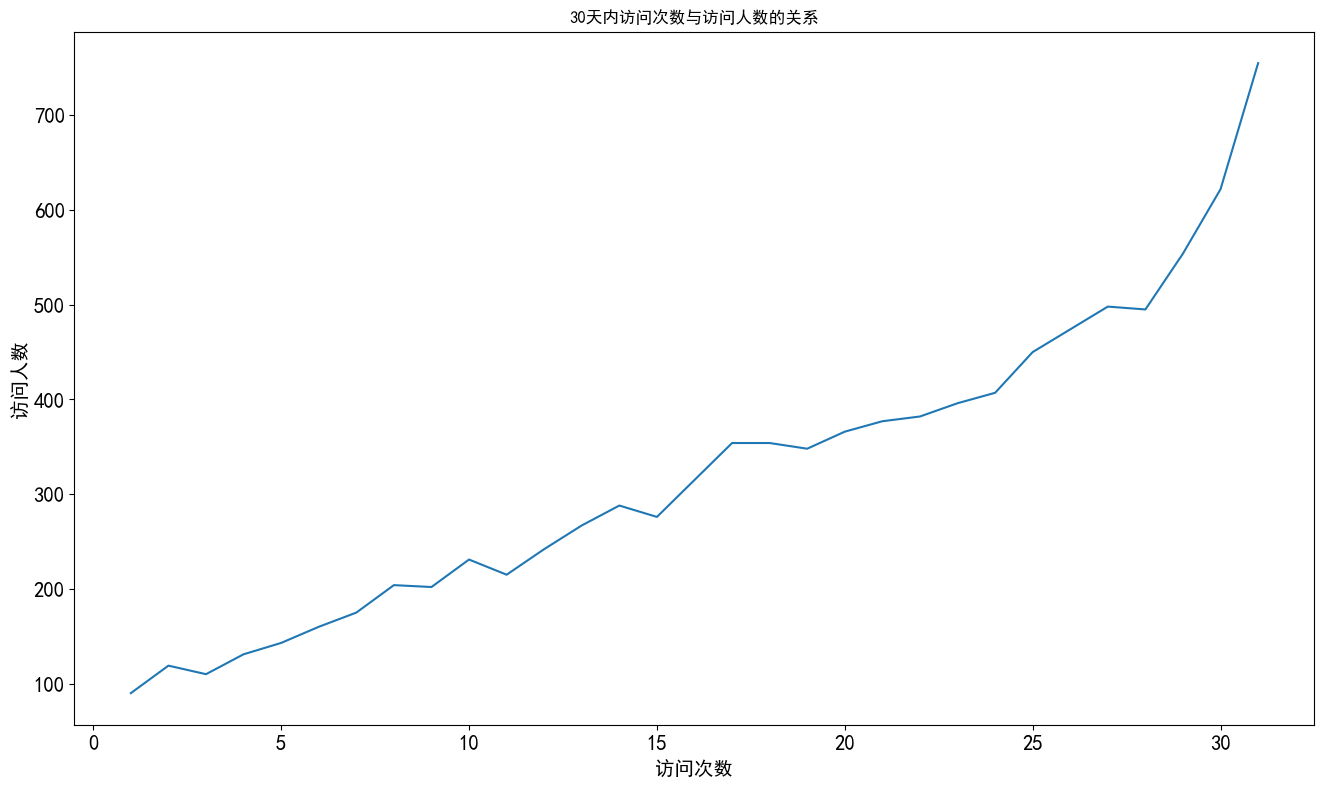

In [17]:
user_active_level = labels['counts_30_active'].value_counts().sort_index(ascending=False)
plt.figure(figsize=(16,9))
user_active_level.plot(title='30天内访问次数与访问人数的关系',fontsize=15)
plt.ylabel('访问人数',fontsize=14)
plt.xlabel('访问次数',fontsize=14)

In [18]:
bins = [0, 5, 10, 15, 20, 25, 30]
user_active_level = pd.cut(labels['counts_30_active'], bins=bins).value_counts().sort_index(ascending=False)
user_active_level

counts_30_active
(25, 30]    2643
(20, 25]    2012
(15, 20]    1737
(10, 15]    1288
(5, 10]      972
(0, 5]       593
Name: count, dtype: int64

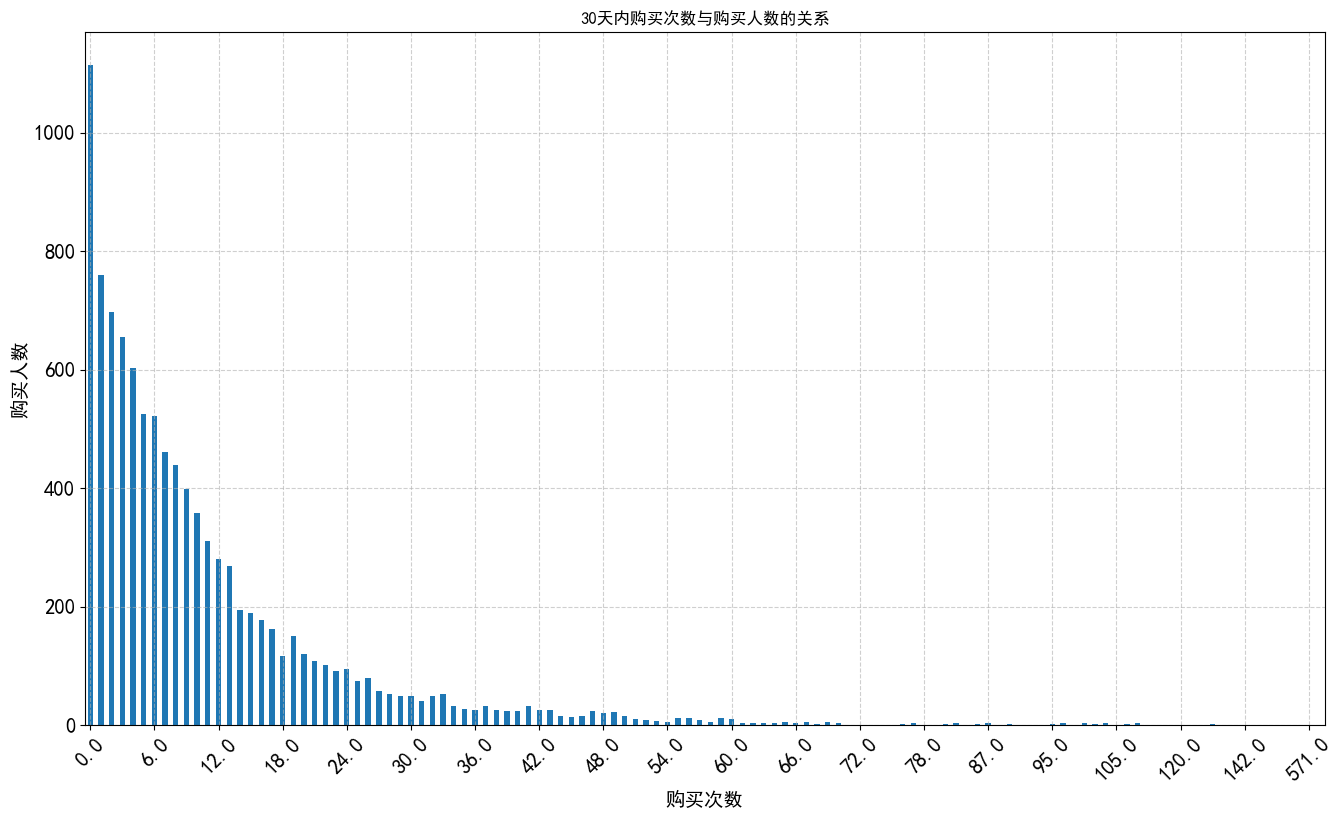

In [19]:
user_buy_level = labels['buy_again'].value_counts().sort_index(ascending=True)  # 按购买次数升序排列
plt.figure(figsize=(16, 9))
user_buy_level.plot(kind='bar', title='30天内购买次数与购买人数的关系', fontsize=15)
plt.ylabel('购买人数', fontsize=14)
plt.xlabel('购买次数', fontsize=14)
plt.xticks(np.arange(0, len(user_buy_level)), user_buy_level.index, rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=20))  # 最多显示10个标签
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
X = labels[['buy_again']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X 是购买次数特征
kmeans = KMeans(n_clusters=2, random_state=42)
labels['cluster'] = kmeans.fit_predict(X_scaled)# 提取购买次数作为特征
# 查看各簇的购买次数范围
cluster_ranges = labels.groupby('cluster')['buy_again'].agg(['min', 'max'])
print(cluster_ranges)

D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


          min    max
cluster             
0         0.0   26.0
1        27.0  770.0


In [21]:
labels['buy_active_level'] = '高'
labels.loc[labels['buy_again']<=26,'buy_active_level'] = '低'
labels

,user_id,counts_30_active,buy_again,cluster,buy_active_level
0,98047837,30,7.0,0,低
1,97726136,28,6.0,0,低
2,98607707,31,25.0,0,低
3,98662432,8,1.0,0,低
4,98145908,11,2.0,0,低
...,...,...,...,...,...
9995,25034174,1,0.0,0,低
9996,5719706,1,1.0,0,低
9997,126412579,1,0.0,0,低
9998,19818801,1,0.0,0,低


In [22]:
df1['date'].max()

Timestamp('2014-12-18 00:00:00')

In [23]:
df1['date'].min()

Timestamp('2014-11-18 00:00:00')

In [24]:
from datetime import datetime
days_buy = df1[df1['behavior_type']==4].groupby('user_id')['date'].max().apply(lambda x:(datetime.strptime('2014-12-19','%Y-%m-%d')-x).days)
labels = pd.merge(labels,days_buy,how='left',on='user_id')
labels

,user_id,counts_30_active,buy_again,cluster,buy_active_level,date
0,98047837,30,7.0,0,低,7.0
1,97726136,28,6.0,0,低,7.0
2,98607707,31,25.0,0,低,1.0
3,98662432,8,1.0,0,低,8.0
4,98145908,11,2.0,0,低,3.0
...,...,...,...,...,...,...
9995,25034174,1,0.0,0,低,NaN
9996,5719706,1,1.0,0,低,3.0
9997,126412579,1,0.0,0,低,NaN
9998,19818801,1,0.0,0,低,NaN


In [25]:
labels.fillna(30, inplace=True)
labels

,user_id,counts_30_active,buy_again,cluster,buy_active_level,date
0,98047837,30,7.0,0,低,7.0
1,97726136,28,6.0,0,低,7.0
2,98607707,31,25.0,0,低,1.0
3,98662432,8,1.0,0,低,8.0
4,98145908,11,2.0,0,低,3.0
...,...,...,...,...,...,...
9995,25034174,1,0.0,0,低,30.0
9996,5719706,1,1.0,0,低,3.0
9997,126412579,1,0.0,0,低,30.0
9998,19818801,1,0.0,0,低,30.0


Text(0.5, 0, '距今天数')

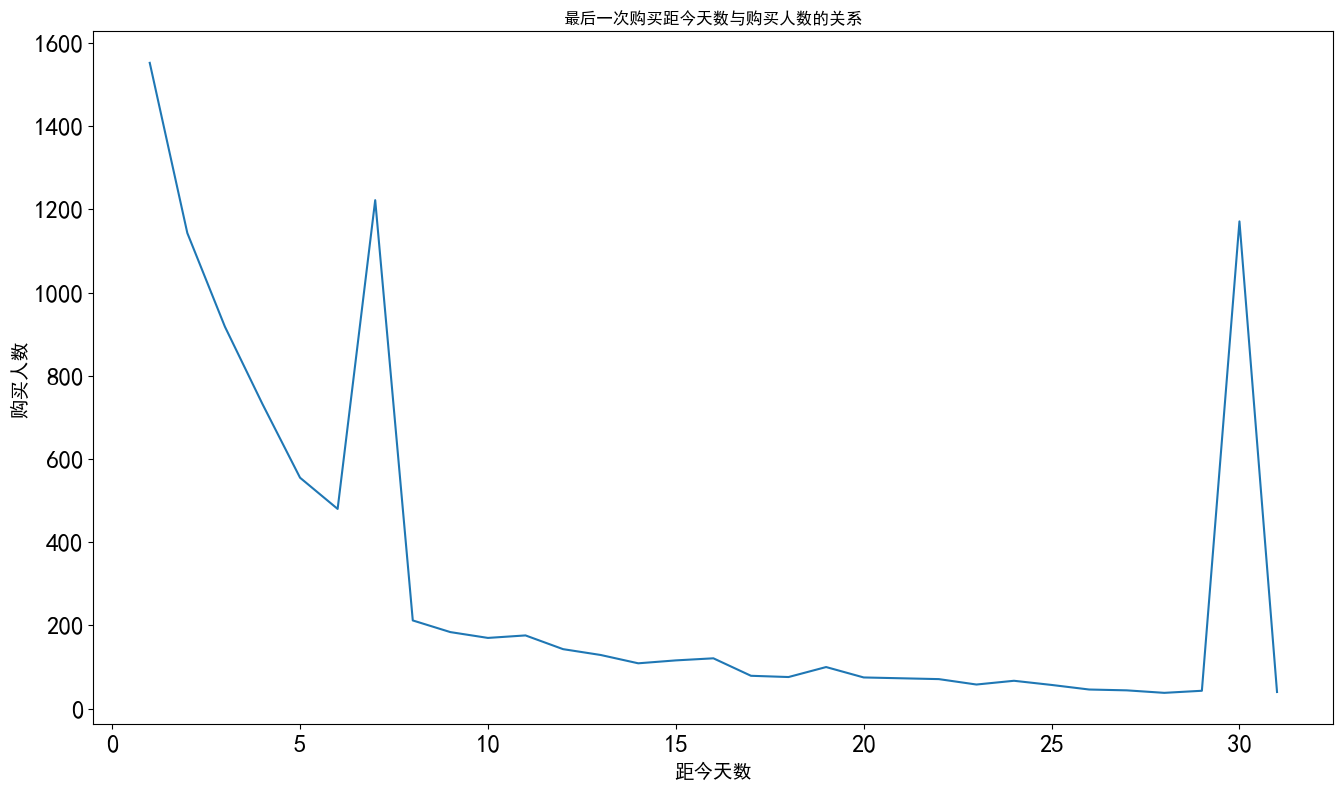

In [26]:
last_buy_days = labels['date'].value_counts().sort_index()
plt.figure(figsize=(16,9))
last_buy_days.plot(title='最后一次购买距今天数与购买人数的关系',fontsize=18)
plt.ylabel('购买人数',fontsize=14)
plt.xlabel('距今天数',fontsize=14)

In [27]:
X = labels[['date']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X 是购买次数特征
kmeans = KMeans(n_clusters=2, random_state=42) #分几类
labels['cluster'] = kmeans.fit_predict(X_scaled)# 提取购买次数作为特征
# 查看各簇的购买次数范围
cluster_ranges = labels.groupby('cluster')['date'].agg(['min', 'max'])
print(cluster_ranges)

D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


          min   max
cluster            
0         1.0  15.0
1        16.0  31.0


In [28]:
labels['buy_days_level'] = '高'
labels.loc[labels['date']>15,'buy_days_level'] = '低'
labels

,user_id,counts_30_active,buy_again,cluster,buy_active_level,date,buy_days_level
0,98047837,30,7.0,0,低,7.0,高
1,97726136,28,6.0,0,低,7.0,高
2,98607707,31,25.0,0,低,1.0,高
3,98662432,8,1.0,0,低,8.0,高
4,98145908,11,2.0,0,低,3.0,高
...,...,...,...,...,...,...,...
9995,25034174,1,0.0,1,低,30.0,低
9996,5719706,1,1.0,0,低,3.0,高
9997,126412579,1,0.0,1,低,30.0,低
9998,19818801,1,0.0,1,低,30.0,低


In [29]:
def trans_value(row):
    x = row['buy_active_level']
    y = row['buy_days_level']
    if x == '高' and y == '高':
        return '重要价值客户'
    elif x == '低' and y == '高':
        return '重要深耕客户'
    elif x == '高' and y == '低':
        return '重要唤回客户'
    else:
        return '即将流失客户'
labels['rfm'] = labels.apply(trans_value, axis=1)
print(labels['rfm'].value_counts())

rfm
重要深耕客户    6896
即将流失客户    2154
重要价值客户     945
重要唤回客户       5
Name: count, dtype: int64


In [30]:
labels

,user_id,counts_30_active,buy_again,cluster,buy_active_level,date,buy_days_level,rfm
0,98047837,30,7.0,0,低,7.0,高,重要深耕客户
1,97726136,28,6.0,0,低,7.0,高,重要深耕客户
2,98607707,31,25.0,0,低,1.0,高,重要深耕客户
3,98662432,8,1.0,0,低,8.0,高,重要深耕客户
4,98145908,11,2.0,0,低,3.0,高,重要深耕客户
...,...,...,...,...,...,...,...,...
9995,25034174,1,0.0,1,低,30.0,低,即将流失客户
9996,5719706,1,1.0,0,低,3.0,高,重要深耕客户
9997,126412579,1,0.0,1,低,30.0,低,即将流失客户
9998,19818801,1,0.0,1,低,30.0,低,即将流失客户
